In [1]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sbn 
import numpy as np
import torch
from scipy.stats import ttest_ind

import re
import ast

In [2]:
# This was unfortunately necessary because I overwrote the original Data.pt file and no longer had access to the original relation -> int 
# mapping. I had to parse the relation mapping from the log files and we will hardcode it here to ensure the results are reproducible.

rel_mapping = """
0 -> ('dbgap_subject', 'mut_missense_variant_deleterious_fwd', 'gene')
1 -> ('gene', 'PHH_lincs_perturbation_rev', 'drug')
2 -> ('gene', 'HT29_lincs_perturbation_rev', 'drug')
3 -> ('drug', 'PC3_lincs_perturbation_fwd', 'gene')
4 -> ('gene', 'associates_fwd', 'disease')
5 -> ('drug', 'A375_lincs_perturbation_fwd', 'gene')
6 -> ('gene', 'predicted_weak_binding_rev', 'drug')
7 -> ('gene', 'high_expr_rev', 'dbgap_subject')
8 -> ('gene', 'MCF7_lincs_perturbation_rev', 'drug')
9 -> ('gene', 'A549_lincs_perturbation_rev', 'drug')
10 -> ('drug', 'predicted_weak_binding_fwd', 'gene')
11 -> ('gene', 'HA1E_lincs_perturbation_rev', 'drug')
12 -> ('gene', 'PC3_lincs_perturbation_rev', 'drug')
13 -> ('gene', 'mut_missense_variant_tolerated_rev', 'dbgap_subject')
14 -> ('pathway', 'isin_rev', 'gene')
15 -> ('drug', 'ASC_lincs_perturbation_fwd', 'gene')
16 -> ('gene', 'ASC_lincs_perturbation_rev', 'drug')
17 -> ('gene', 'low_expr_rev', 'dbgap_subject')
18 -> ('drug', 'HT29_lincs_perturbation_fwd', 'gene')
19 -> ('drug', 'predicted_conf_weak_binding_fwd', 'gene')
20 -> ('disease', 'associates_rev', 'drug')
21 -> ('gene', 'predicted_conf_weak_binding_rev', 'drug')
22 -> ('drug', 'resistant_to_rev', 'dbgap_subject')
23 -> ('drug', 'A549_lincs_perturbation_fwd', 'gene')
24 -> ('drug', 'associates_fwd', 'disease')
25 -> ('gene', 'protbert_similarity', 'gene')
26 -> ('dbgap_subject', 'resistant_to_fwd', 'drug')
27 -> ('gene', 'predicted_strong_binding_rev', 'drug')
28 -> ('drug', 'VCAP_lincs_perturbation_fwd', 'gene')
29 -> ('drug', 'chemberta_cosine_similarity', 'drug')
30 -> ('dbgap_subject', 'sensitive_to_fwd', 'drug')
31 -> ('drug', 'sensitive_to_rev', 'dbgap_subject')
32 -> ('dbgap_subject', 'low_expr_fwd', 'gene')
33 -> ('gene', 'isin_fwd', 'pathway')
34 -> ('drug', 'targets', 'gene')
35 -> ('gene', 'mut_missense_variant_deleterious_rev', 'dbgap_subject')
36 -> ('gene', 'A375_lincs_perturbation_rev', 'drug')
37 -> ('gene', 'SKB_lincs_perturbation_rev', 'drug')
38 -> ('drug', 'HA1E_lincs_perturbation_fwd', 'gene')
39 -> ('gene', 'NPC_lincs_perturbation_rev', 'drug')
40 -> ('drug', 'NPC_lincs_perturbation_fwd', 'gene')
41 -> ('dbgap_subject', 'mut_missense_variant_tolerated_fwd', 'gene')
42 -> ('drug', 'SKB_lincs_perturbation_fwd', 'gene')
43 -> ('drug', 'predicted_strong_binding_fwd', 'gene')
44 -> ('gene', 'VCAP_lincs_perturbation_rev', 'drug')
45 -> ('disease', 'associates_rev', 'gene')
46 -> ('dbgap_subject', 'high_expr_fwd', 'gene')
47 -> ('drug', 'MCF7_lincs_perturbation_fwd', 'gene')
48 -> ('drug', 'PHH_lincs_perturbation_fwd', 'gene')'
"""


# Compile a pattern that captures:
#  1) the integer index
#  2) everything in parentheses (the 3-tuple), including commas.
pattern = re.compile(r"(\d+)\s*->\s*(\(.+\))")

parsed_dict = {}

for line in rel_mapping.splitlines():
    line = line.strip()
    if not line or '->' not in line:
        continue
    
    match = pattern.search(line)
    if match:
        idx_str, tuple_str = match.groups()
        idx = int(idx_str)
        # Clean trailing apostrophes if there's an extra ' at the end:
        tuple_str = tuple_str.rstrip("'")  
        # Safely evaluate the string as a Python tuple
        relation_tuple = ast.literal_eval(tuple_str)
        
        parsed_dict[idx] = relation_tuple

In [3]:
target_metric = 'MRR'
partition = 'valid'
alpha = 0.15
group_relation_directions = False # so _fwd and _rev edges will be listed as having the same relation type

In [4]:
def remove_dir(rel): 
    rel = rel.split('->')[1]
    if rel.endswith('_fwd') or rel.endswith('_rev'):
        return rel[:-4]
    else: 
        return rel

In [5]:
cpx_res = pd.read_csv(f'/home/teddy/local/TKG-DTI/output/ablation/tkge/COMPLEX2/{partition}_metrics.csv')
gnn_res = pd.read_csv(f'/home/teddy/local/TKG-DTI/output/ablation/tkge/GNN/{partition}_metrics.csv')
#data = torch.load('/home/teddy/local/TKG-DTI/data/tkg/processed/FOLD_0/Data.pt', weights_only=False)

print('# entries (COMPLEX2):', cpx_res.shape[0])
print('# entries (GNN):', gnn_res.shape[0])

#rel2int = {k:v[0] for k,v in data.edge_reltype.items()} 
#int2rel = {v:'->'.join(k) for k,v in rel2int.items()}
int2rel = {k:'->'.join(v) for k,v in parsed_dict.items()}

if group_relation_directions: 
    int2rel = {k:remove_dir(v) for k,v in int2rel.items()}

cpx_res = cpx_res.assign(remove_relation = cpx_res.remove_relation_idx.apply(lambda x: int2rel.get(x, 'None')))
gnn_res = gnn_res.assign(remove_relation = gnn_res.remove_relation_idx.apply(lambda x: int2rel.get(x, 'None')))

all_cpx = cpx_res.copy()
all_gnn = gnn_res.copy()

# entries (COMPLEX2): 133
# entries (GNN): 157


In [6]:
cpx_res.head()

,optim,lr,wd,channels,batch_size,n_epochs,lr_scheduler,dropout,remove_relation_idx,MRR,Top1,Top3,Top10,Top100,avg_AUC,avg_AP,avg_Brier,ECE,uid,remove_relation
0,adam,0.001,0.000001,512,5000,100,False,0.0,1.0,0.188033,0.119835,0.206612,0.309917,0.690083,0.923916,0.285360,0.123485,0.308615,c4c07e3d-9336-41e0-ad33-c3c64901fbff,gene->PHH_lincs_perturbation_rev->drug
1,adam,0.001,0.000001,512,5000,100,False,0.0,2.0,0.213901,0.136364,0.219008,0.376033,0.706612,0.939652,0.333929,0.104175,0.274516,48a45913-6812-414f-b6f5-87b40e3f8793,gene->HT29_lincs_perturbation_rev->drug
2,adam,0.001,0.000001,512,5000,100,False,0.0,1.0,0.166429,0.082645,0.190083,0.342975,0.652893,0.945325,0.254152,0.122505,0.307282,abd3ccf0-95ec-4275-929d-bb2de60102cc,gene->PHH_lincs_perturbation_rev->drug
3,adam,0.001,0.000001,512,5000,100,False,0.0,3.0,0.195830,0.115702,0.219008,0.367769,0.685950,0.925975,0.318356,0.105999,0.278447,0faa3234-a9b2-4ec1-bb9e-e995c94fa00d,drug->PC3_lincs_perturbation_fwd->gene
4,adam,0.001,0.000001,512,5000,100,False,0.0,6.0,0.180900,0.103306,0.181818,0.359504,0.698347,0.931068,0.293487,0.124845,0.308770,71b3f9a6-de7c-480f-9bbf-f86298077238,gene->predicted_weak_binding_rev->drug


In [7]:
cpx_pval = {'remove_relation':[], 'pval':[], 'tstat':[], 'nx':[], 'ny':[]} 

for rel in cpx_res.remove_relation.unique():

    x = cpx_res[cpx_res.remove_relation == 'None'][target_metric].values
    y = cpx_res[cpx_res.remove_relation == rel][target_metric].values

    nx = len(x)
    ny = len(y)

    tstat, pval = ttest_ind(x, y, equal_var=False)

    cpx_pval['remove_relation'].append(rel)
    cpx_pval['pval'].append(pval)
    cpx_pval['tstat'].append(tstat)
    cpx_pval['nx'].append(nx)
    cpx_pval['ny'].append(ny)

cpx_pval = pd.DataFrame(cpx_pval)

/home/teddy/miniconda3/envs/tkgdti/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/teddy/miniconda3/envs/tkgdti/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [8]:
gnn_pval = {'remove_relation':[], 'pval':[], 'tstat':[], 'nx':[], 'ny':[]}

for rel in gnn_res.remove_relation.unique():

    x = gnn_res[gnn_res.remove_relation == 'None'][target_metric].values
    y = gnn_res[gnn_res.remove_relation == rel][target_metric].values

    nx = len(x)
    ny = len(y)

    tstat, pval = ttest_ind(x, y, equal_var=False)

    gnn_pval['remove_relation'].append(rel)
    gnn_pval['pval'].append(pval)
    gnn_pval['tstat'].append(tstat)
    gnn_pval['nx'].append(nx)
    gnn_pval['ny'].append(ny)

gnn_pval = pd.DataFrame(gnn_pval)

In [9]:
cpx_res = cpx_res[['remove_relation', 'MRR', 'avg_AUC', 'Top1', 'Top3']].groupby('remove_relation').mean().reset_index()
cpx_none = cpx_res.loc[cpx_res.remove_relation == 'None']
cpx_deltas = cpx_res[['MRR', 'avg_AUC', 'Top1', 'Top3']] - cpx_none[['MRR', 'avg_AUC', 'Top1', 'Top3']].values
cpx_deltas.columns = [f'{c}_delta' for c in cpx_deltas.columns]
cpx_res = pd.concat([cpx_res, cpx_deltas], axis=1)
cpx_res = cpx_res.merge(cpx_pval, on='remove_relation', how='left')

gnn_res = gnn_res[['remove_relation', 'MRR', 'avg_AUC', 'Top1', 'Top3']].groupby('remove_relation').mean().reset_index()
gnn_none = gnn_res.loc[gnn_res.remove_relation == 'None']
gnn_deltas = gnn_res[['MRR', 'avg_AUC', 'Top1', 'Top3']] - gnn_none[['MRR', 'avg_AUC', 'Top1', 'Top3']].values
gnn_deltas.columns = [f'{c}_delta' for c in gnn_deltas.columns]
gnn_res = pd.concat([gnn_res, gnn_deltas], axis=1)
gnn_res = gnn_res.merge(gnn_pval, on='remove_relation', how='left')

cpx_res = cpx_res.assign(model='COMPLEX2')
gnn_res = gnn_res.assign(model='GNN') 
res = pd.concat([cpx_res, gnn_res], axis=0)
res = res.sort_values(by=target_metric, ascending=False)
res = res.assign(detrimental = res.tstat < 0)
                         
res.head()

,remove_relation,MRR,avg_AUC,Top1,Top3,MRR_delta,avg_AUC_delta,Top1_delta,Top3_delta,pval,tstat,nx,ny,model,detrimental
44,gene->predicted_conf_weak_binding_rev->drug,0.204459,0.936825,0.119835,0.235537,0.015578,-0.001767,0.006198,0.034298,0.205303,-2.344298,10,2,COMPLEX2,True
11,drug->ASC_lincs_perturbation_fwd->gene,0.204348,0.935685,0.126033,0.223140,0.015467,-0.002907,0.012397,0.021901,0.000105,-6.329605,10,2,COMPLEX2,True
24,drug->predicted_weak_binding_fwd->gene,0.203386,0.934541,0.132231,0.203857,0.014505,-0.004051,0.018595,0.002617,0.003971,-4.303376,10,3,COMPLEX2,True
21,drug->chemberta_cosine_similarity->drug,0.202905,0.952655,0.126033,0.219008,0.014024,0.014063,0.012397,0.017769,0.351351,-1.500012,10,2,COMPLEX2,True
31,gene->HT29_lincs_perturbation_rev->drug,0.199556,0.944361,0.125344,0.202479,0.010676,0.005769,0.011708,0.001240,0.315298,-1.267839,10,3,COMPLEX2,True


In [10]:
res_wide = res[['model', 'remove_relation', 'pval', 'detrimental']].pivot(index='remove_relation', columns='model', values=['pval', 'detrimental'])

res_wide = res_wide.assign(likely_detrimental_to_one = ((res_wide.pval.GNN < alpha) & res_wide.detrimental.GNN.astype(bool)) | ((res_wide.pval.COMPLEX2 < alpha) & res_wide.detrimental.COMPLEX2.astype(bool)))

res_wide = res_wide.assign(likely_beneficial_to_one = ((res_wide.pval.GNN < alpha) & ~res_wide.detrimental.GNN.astype(bool)) | ((res_wide.pval.COMPLEX2 < alpha) & ~res_wide.detrimental.COMPLEX2.astype(bool)))

res_wide = res_wide[lambda x: x.likely_detrimental_to_one & ~x.likely_beneficial_to_one]

res_wide.reset_index().style.hide()

In [11]:
res_wide.index.tolist()

['drug->ASC_lincs_perturbation_fwd->gene',
 'drug->predicted_weak_binding_fwd->gene',
 'gene->A549_lincs_perturbation_rev->drug',
 'gene->NPC_lincs_perturbation_rev->drug',
 'gene->associates_fwd->disease',
 'gene->high_expr_rev->dbgap_subject',
 'gene->isin_fwd->pathway',
 'gene->mut_missense_variant_deleterious_rev->dbgap_subject',
 'gene->predicted_weak_binding_rev->drug']

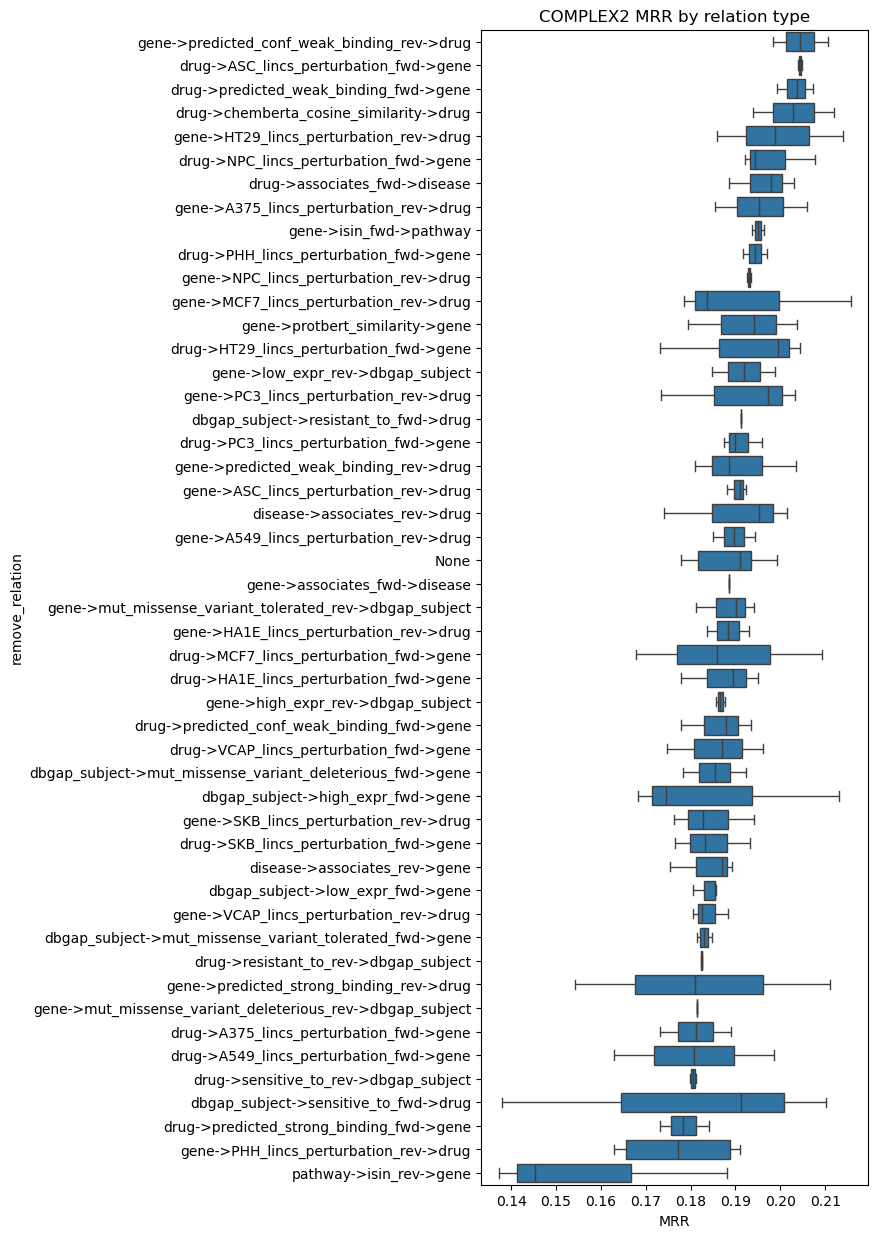

In [12]:
plt.figure(figsize=(5,15)) 
plt.title(f'COMPLEX2 {target_metric} by relation type')
sbn.boxplot(y='remove_relation', x=target_metric, data=all_cpx, order=all_cpx.groupby('remove_relation')[[target_metric]].mean().sort_values(by=target_metric, ascending=False).index.tolist())
plt.show()

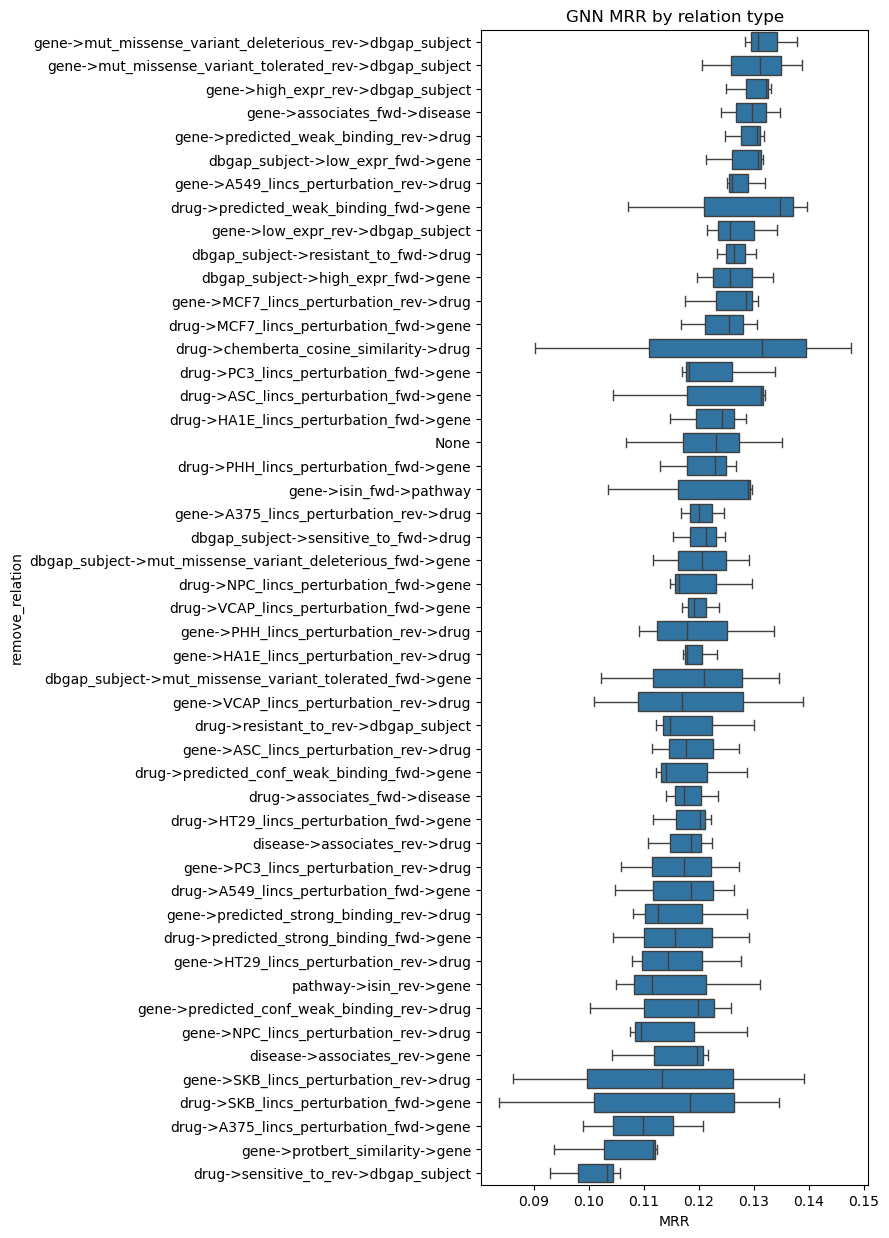

In [13]:
plt.figure(figsize=(5, 15)) 
plt.title(f'GNN {target_metric} by relation type')
sbn.boxplot(y='remove_relation', x=target_metric, data=all_gnn, order=all_gnn.groupby('remove_relation')[[target_metric]].mean()\
            .sort_values(by=target_metric, ascending=False).index.tolist())
plt.show()

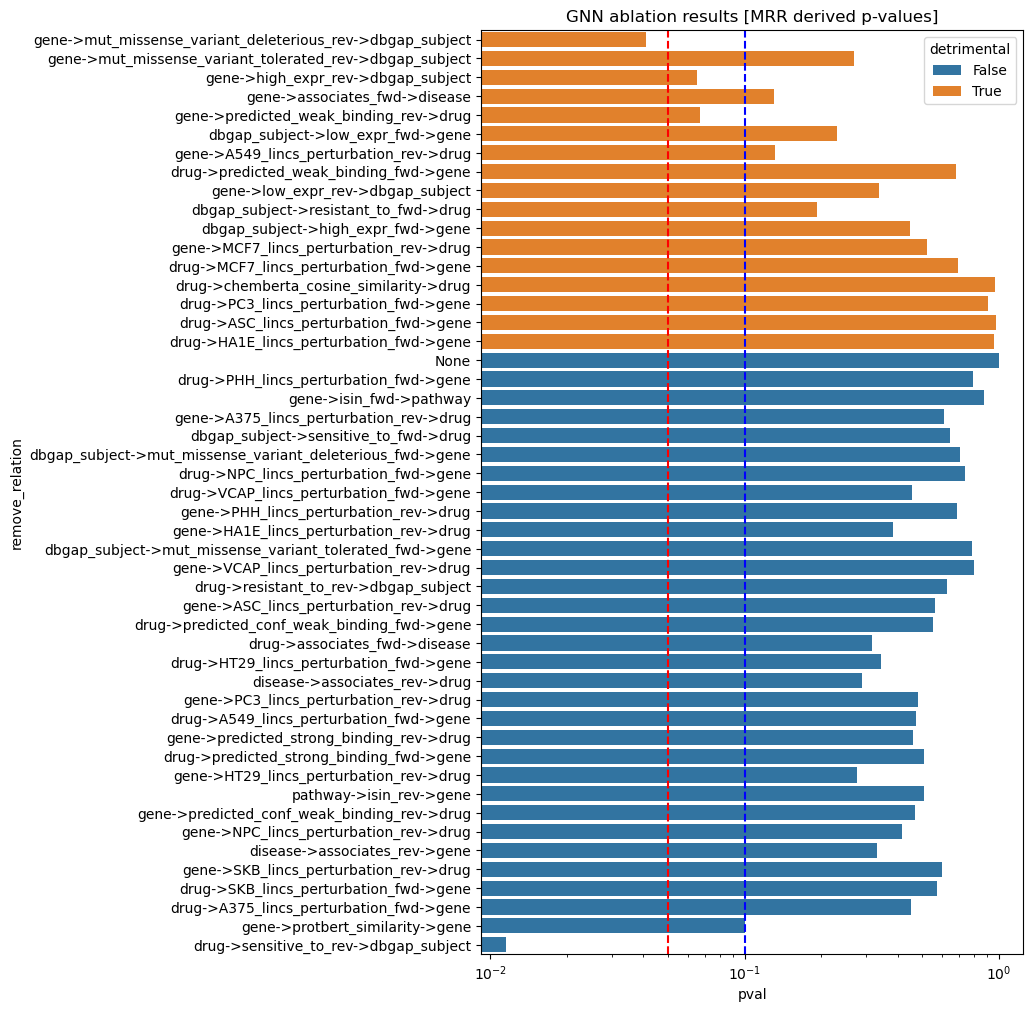

In [14]:
plt.figure(figsize=(7,12)) 
sbn.barplot(x='pval', y='remove_relation', hue='detrimental', data=res[lambda x: x.model == 'GNN'].reset_index())
plt.xscale('log')
plt.axvline(0.05, color='red', linestyle='--', label='0.05')
plt.axvline(0.1, color='blue', linestyle='--', label='0.1')
plt.title(f'GNN ablation results [{target_metric} derived p-values]')
plt.show()

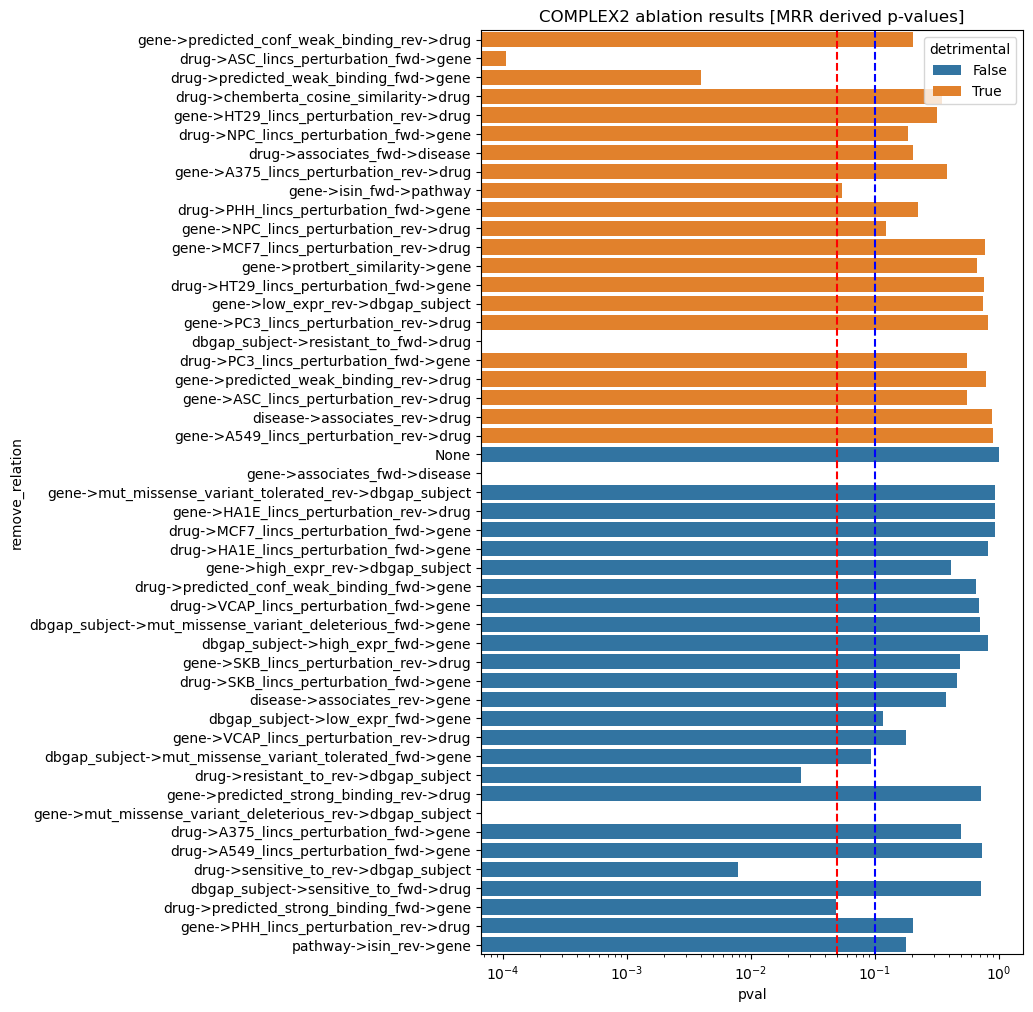

In [15]:
plt.figure(figsize=(7,12)) 
sbn.barplot(x='pval', y='remove_relation', hue='detrimental', data=res[lambda x: x.model == 'COMPLEX2'].reset_index())
plt.xscale('log')
plt.axvline(0.05, color='red', linestyle='--')
plt.axvline(0.1, color='blue', linestyle='--', label='0.1')
plt.title(f'COMPLEX2 ablation results [{target_metric} derived p-values]')
plt.show()

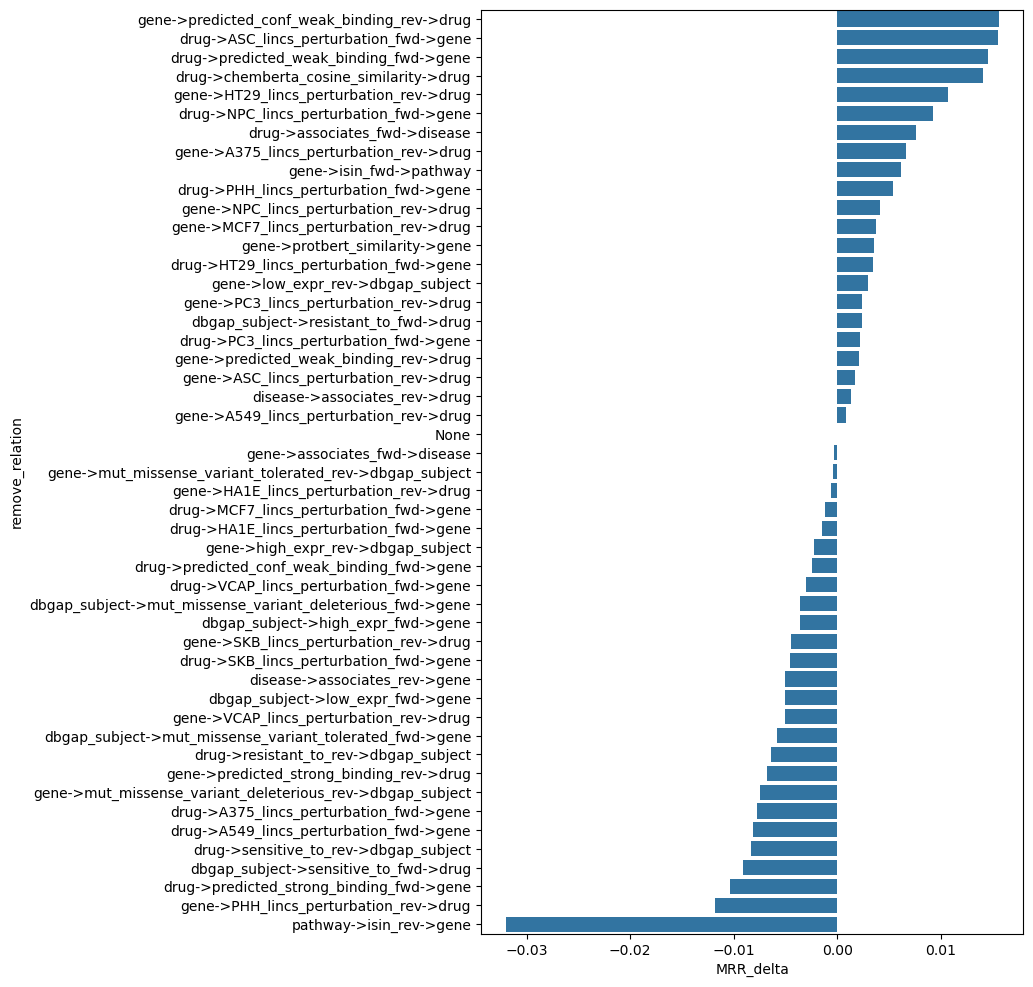

In [16]:
plt.figure(figsize=(7,12)) 
sbn.barplot(x=f'{target_metric}_delta', y='remove_relation', data=res[lambda x: x.model == 'COMPLEX2'])
plt.show()

In [17]:
res = res.assign(reverse_edge = lambda x: x.remove_relation.str.contains('_rev-'))

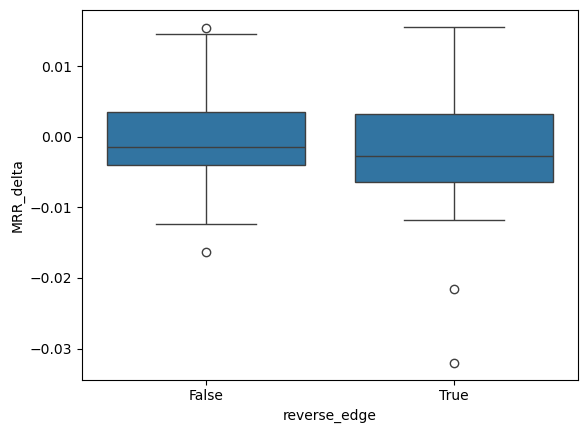

In [18]:
plt.figure()
sbn.boxplot(x='reverse_edge', y=f'{target_metric}_delta', data=res)
plt.show()

In [19]:
all_cpx.sort_values(by=target_metric, ascending=False).head(1)

,optim,lr,wd,channels,batch_size,n_epochs,lr_scheduler,dropout,remove_relation_idx,MRR,Top1,Top3,Top10,Top100,avg_AUC,avg_AP,avg_Brier,ECE,uid,remove_relation
9,adam,0.001,0.000001,512,5000,100,False,0.0,8.0,0.215714,0.140496,0.231405,0.355372,0.706612,0.955665,0.335811,0.109298,0.283145,b2e49246-9cc3-49b3-b0bb-3832605cd5ec,gene->MCF7_lincs_perturbation_rev->drug


In [20]:
all_gnn.sort_values(by=target_metric, ascending=False).head(1)

,model,lr,wd,channels,batch_size,n_epochs,layers,num_workers,nonlin,heads,...,Top1,Top3,Top10,Top100,avg_AUC,avg_AP,avg_Brier,ECE,uid,remove_relation
140,path-gnn,0.01,1.000000e-07,16,5,100,4,10,elu,2,...,0.099174,0.14876,0.219008,0.661157,0.967878,0.198386,0.000254,0.000151,af5f4101-1cd9-48de-bb96-63d9aaba9878,drug->chemberta_cosine_similarity->drug


In [21]:
res_wide = res.pivot(index='remove_relation', columns='model', values='MRR_delta')
res_wide = res_wide.assign(avg=res_wide.mean(axis=1))
res_wide = res_wide.sort_values(by='avg', ascending=False)
res_wide.head(15)

model,COMPLEX2,GNN,avg
remove_relation,,,
drug->predicted_weak_binding_fwd->gene,0.014505,0.004894,0.009700
drug->ASC_lincs_perturbation_fwd->gene,0.015467,0.000306,0.007887
drug->chemberta_cosine_similarity->drug,0.014024,0.000894,0.007459
gene->predicted_weak_binding_rev->drug,0.002092,0.006826,0.004459
gene->predicted_conf_weak_binding_rev->drug,0.015578,-0.006965,0.004306
gene->low_expr_rev->dbgap_subject,0.002980,0.004875,0.003928
gene->mut_missense_variant_tolerated_rev->dbgap_subject,-0.000409,0.007879,0.003735
drug->NPC_lincs_perturbation_fwd->gene,0.009258,-0.001925,0.003666
gene->MCF7_lincs_perturbation_rev->drug,0.003739,0.003373,0.003556


In [22]:
res_wide.tail(20)

model,COMPLEX2,GNN,avg
remove_relation,,,
gene->HA1E_lincs_perturbation_rev->drug,-0.000567,-0.002828,-0.001698
disease->associates_rev->drug,0.001363,-0.005013,-0.001825
dbgap_subject->mut_missense_variant_deleterious_fwd->gene,-0.003558,-0.001779,-0.002668
drug->VCAP_lincs_perturbation_fwd->gene,-0.002982,-0.002397,-0.002689
drug->predicted_conf_weak_binding_fwd->gene,-0.002485,-0.003906,-0.003195
gene->VCAP_lincs_perturbation_rev->drug,-0.005052,-0.003250,-0.004151
dbgap_subject->mut_missense_variant_tolerated_fwd->gene,-0.005863,-0.002974,-0.004419
drug->resistant_to_rev->dbgap_subject,-0.006439,-0.003274,-0.004857
dbgap_subject->sensitive_to_fwd->drug,-0.009075,-0.001775,-0.005425


COMPLEX-GNN MRR DELTAS CORR 0.20612244897959184


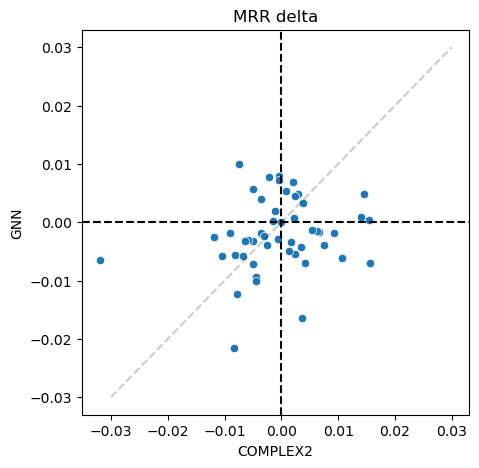

In [23]:
r = res_wide.corr(method='spearman').values[0,1]
print('COMPLEX-GNN MRR DELTAS CORR', r)

plt.figure(figsize=(5,5))
sbn.scatterplot(x='COMPLEX2', y='GNN', data=res_wide.reset_index())
plt.axvline(0, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.plot([-0.03, 0.03], [-0.03, 0.03], color='black', linestyle='--', alpha =0.2)
plt.title('MRR delta')
plt.show()


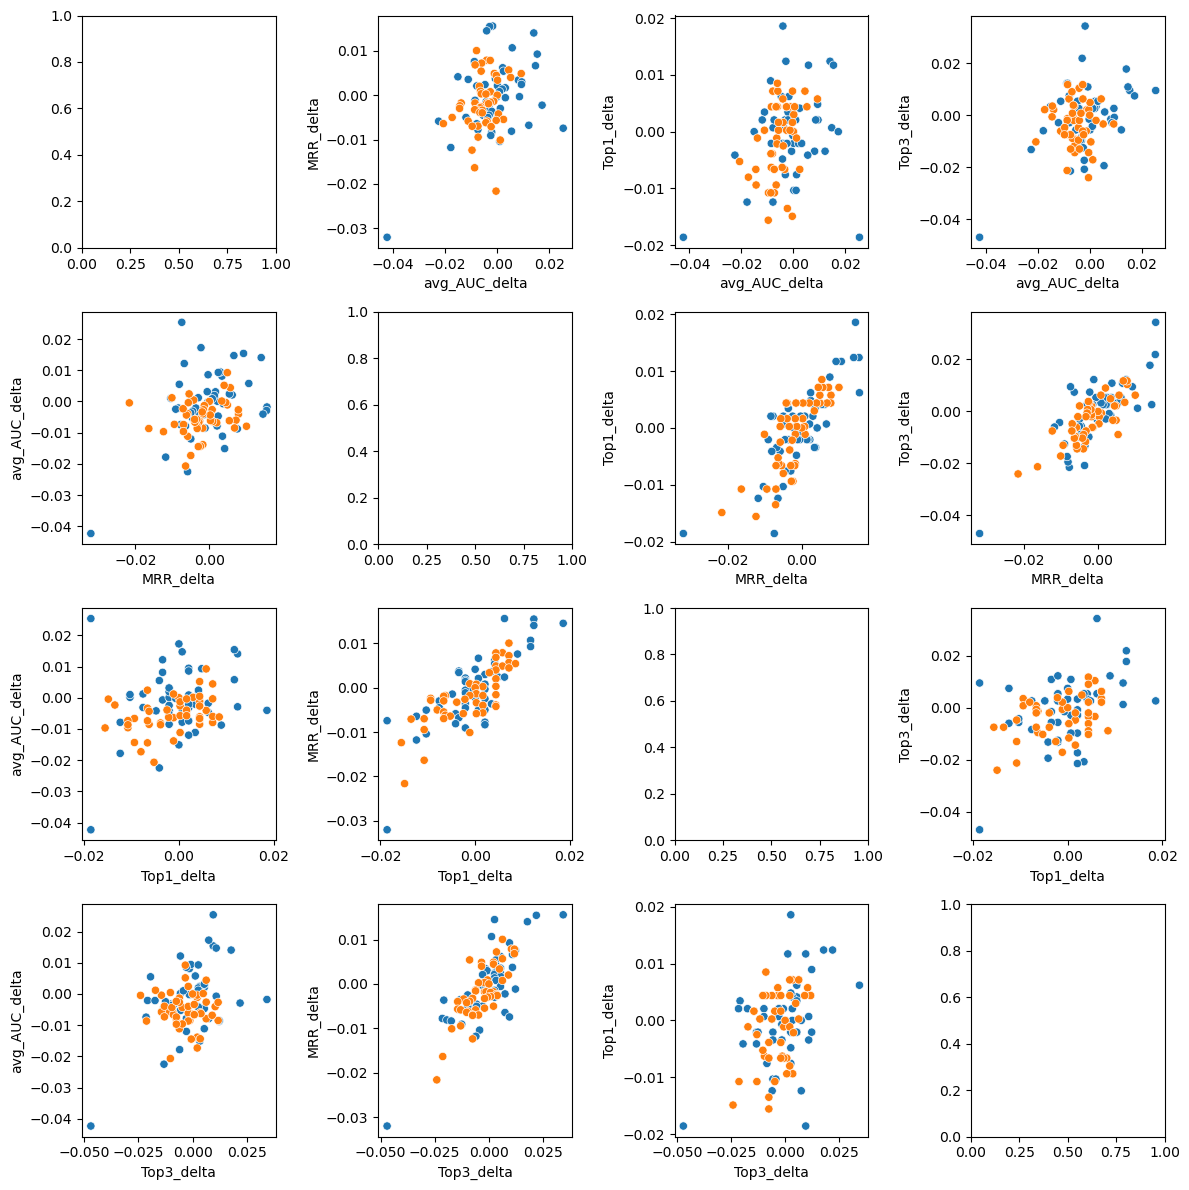

In [24]:

f,axes = plt.subplots(4,4, figsize=(12,12))


for i,xx in enumerate(['avg_AUC_delta', 'MRR_delta', 'Top1_delta', 'Top3_delta']):
    for j, yy in enumerate(['avg_AUC_delta', 'MRR_delta', 'Top1_delta', 'Top3_delta']):
        if xx == yy:
            continue

        sbn.scatterplot(x=xx, y=yy, hue='model', data=res, ax=axes[i,j], legend=False)

plt.tight_layout()
plt.show()



In [25]:


# ttest 

# remove sig detrimental relations 

# run hparam tuning 

# prepare results for anupriya 